In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
import scikitplot as skplt
from wordcloud import WordCloud

In [3]:
from bs4 import BeautifulSoup
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [5]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
import tokenization

In [7]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/steam-recommendation-nlp-dataset/game_overview.csv
/kaggle/input/steam-recommendation-nlp-dataset/test.csv
/kaggle/input/steam-recommendation-nlp-dataset/train.csv
/kaggle/input/submission/submission1.csv


In [8]:
df = pd.read_csv('/kaggle/input/steam-recommendation-nlp-dataset/train.csv')
game_df = pd.read_csv('/kaggle/input/steam-recommendation-nlp-dataset/game_overview.csv')

In [9]:
testing_df=  pd.read_csv('/kaggle/input/steam-recommendation-nlp-dataset/test.csv')

In [10]:
testing_df.drop(["review_id","title","year"],axis=1,inplace=True)

In [11]:
testing_df.head(2)

,user_review
0,"Nice graphics, new maps, weapons and models. B..."
1,I would not recommend getting into this at its...


In [12]:
df.drop(['review_id'],axis=1,inplace=True)

In [13]:
result = pd.merge(df, game_df,on='title', how='left')

In [14]:
result.drop(['year'],axis=1,inplace=True)
result.tail(5)

,title,user_review,user_suggestion,developer,publisher,tags,overview
17489,EverQuest II,Arguably the single greatest mmorp that exists...,1,Daybreak Game Company,Daybreak Game Company,"['Free to Play', 'Massively Multiplayer', 'RPG...",EverQuest® II is the epitome of massively mult...
17490,EverQuest II,"An older game, to be sure, but has its own cha...",1,Daybreak Game Company,Daybreak Game Company,"['Free to Play', 'Massively Multiplayer', 'RPG...",EverQuest® II is the epitome of massively mult...
17491,EverQuest II,When I frist started playing Everquest 2 it wa...,1,Daybreak Game Company,Daybreak Game Company,"['Free to Play', 'Massively Multiplayer', 'RPG...",EverQuest® II is the epitome of massively mult...
17492,EverQuest II,cool game. THe only thing that REALLY PISSES M...,1,Daybreak Game Company,Daybreak Game Company,"['Free to Play', 'Massively Multiplayer', 'RPG...",EverQuest® II is the epitome of massively mult...
17493,EverQuest II,"this game since I was a little kid, always hav...",1,Daybreak Game Company,Daybreak Game Company,"['Free to Play', 'Massively Multiplayer', 'RPG...",EverQuest® II is the epitome of massively mult...


In [15]:
result.isnull().any()

title              False
user_review        False
user_suggestion    False
developer          False
publisher          False
tags               False
overview           False
dtype: bool

In [16]:
result.drop(["overview","developer","publisher"],axis=1,inplace=True)

In [17]:
result.head(2)

,title,user_review,user_suggestion,tags
0,Spooky's Jump Scare Mansion,I'm scared and hearing creepy voices. So I'll...,1,"['Horror', 'Free to Play', 'Cute', 'First-Pers..."
1,Spooky's Jump Scare Mansion,"Best game, more better than Sam Pepper's YouTu...",1,"['Horror', 'Free to Play', 'Cute', 'First-Pers..."


In [18]:
testing_df.head(2)

,user_review
0,"Nice graphics, new maps, weapons and models. B..."
1,I would not recommend getting into this at its...


# Text Processing

In [19]:
def punctuation_removal(messy_str):
    clean_list = [char for char in messy_str if char not in string.punctuation]
    clean_str = ''.join(clean_list)
    return clean_str

In [20]:
result['user_review'] = result['user_review'].apply(punctuation_removal)
testing_df['user_review'] = testing_df['user_review'].apply(punctuation_removal)


In [21]:

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
stop = stopwords.words('english')

In [22]:
stop.remove('not')
stop.remove("don't")

In [23]:
stop_words = []

for item in stop: 
    new_item = punctuation_removal(item)
    stop_words.append(new_item) 
# print(stop_words)

In [24]:
def stopwords_removal(messy_str):
    messy_str = word_tokenize(messy_str)
    return [word.lower() for word in messy_str 
            if word.lower() not in stop_words ]

In [25]:
result['user_review'] = result['user_review'].apply(stopwords_removal)
testing_df['user_review'] = testing_df['user_review'].apply(stopwords_removal)


In [26]:
result.head(2)



,title,user_review,user_suggestion,tags
0,Spooky's Jump Scare Mansion,"[im, scared, hearing, creepy, voices, ill, pau...",1,"['Horror', 'Free to Play', 'Cute', 'First-Pers..."
1,Spooky's Jump Scare Mansion,"[best, game, better, sam, peppers, youtube, ac...",1,"['Horror', 'Free to Play', 'Cute', 'First-Pers..."


In [27]:
import re
def drop_numbers(list_text):
    list_text_new = []
    for i in list_text:
        if not re.search('\d', i):
            list_text_new.append(i)
    return ' '.join(list_text_new)
result['user_review'] = result['user_review'].apply(drop_numbers)
testing_df['user_review'] = testing_df['user_review'].apply(drop_numbers)


In [28]:
result.head(2)

,title,user_review,user_suggestion,tags
0,Spooky's Jump Scare Mansion,im scared hearing creepy voices ill pause mome...,1,"['Horror', 'Free to Play', 'Cute', 'First-Pers..."
1,Spooky's Jump Scare Mansion,best game better sam peppers youtube account n...,1,"['Horror', 'Free to Play', 'Cute', 'First-Pers..."


In [29]:
from textblob import TextBlob
example = "This game is scary and i would recommend it playing"
blob = TextBlob(example)
blob.sentiment

Sentiment(polarity=-0.45, subjectivity=0.7)

#Note that the subjectivity is still high as it is still an opinion and not a fact

In [30]:
result_reviews = result['user_review'] 
testing_reviews = testing_df['user_review'] 

In [31]:
from tqdm import tqdm
result_sentiments = []
for review in tqdm(result_reviews):
    blob = TextBlob(review)
    result_sentiments += [blob.sentiment.polarity]

100%|██████████| 17494/17494 [00:20<00:00, 848.42it/s] 


In [32]:
from tqdm import tqdm
testing_sentiments = []
for review in tqdm(testing_reviews):
    blob = TextBlob(review)
    testing_sentiments += [blob.sentiment.polarity]

100%|██████████| 8045/8045 [00:09<00:00, 866.41it/s]


In [33]:
result['sentiment'] = result_sentiments
testing_df['sentiment'] =testing_sentiments

In [34]:
loaded_submission = pd.read_csv('/kaggle/input/submission/submission1.csv')
loaded_submission.tail()
loaded_submission['sentiment'] = testing_df['sentiment']

In [35]:
result.user_review[13978] = "good game"

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [36]:
result.user_review[13978]

'good game'

In [37]:
result.sample(20)

,title,user_review,user_suggestion,tags,sentiment
3703,Team Fortress 2,pimply foulmouthed misanthropic problem drinki...,0,"['Free to Play', 'Multiplayer', 'FPS', 'Action...",0.236526
12431,RaceRoom Racing Experience,first game extremely hard keyboard actually wo...,1,"['Racing', 'Free to Play', 'Multiplayer', 'Sim...",0.002222
5282,Brawlhalla,early access reviewfyi review opinion based al...,0,"['Free to Play', 'Multiplayer', 'Fighting', '2...",-0.039015
15244,Business Tour - Board Game with Online Multipl...,not pay win fck ai fcking bugged push lose buy...,0,"['Free to Play', 'Board Game', 'Strategy', 'Ma...",0.140476
11777,Bless Online,product received freeearly access reviewbless ...,1,"['MMORPG', 'Open World', 'Massively Multiplaye...",0.276923
9640,Realm of the Mad God,well first realm mad god game spent quite time...,1,"['Free to Play', 'Massively Multiplayer', 'Pix...",0.026786
2183,Path of Exile,best game moment lot fun lot content lot endga...,1,"['Free to Play', 'Action RPG', 'Hack and Slash...",0.300000
1013,Fractured Space,early access reviewmy criticisms edge case see...,1,"['Space', 'Multiplayer', 'Free to Play', 'PvP'...",0.058333
12732,RaceRoom Racing Experience,strongly advise not get game seems extremeley ...,0,"['Racing', 'Free to Play', 'Multiplayer', 'Sim...",-0.152381
11404,Black Squad,early access reviewok need say game good free ...,1,"['Early Access', 'Free to Play', 'FPS', 'Multi...",0.256667


# Correlation with ratings

Let's see if the newly calculated sentiments have any correlation with the ratings. Our hypothesis would be that reviews with postive reviews would have higher polarity values and vice-versa.

In [38]:
np.corrcoef(result["user_suggestion"], result["sentiment"])

array([[1.       , 0.3748949],
       [0.3748949, 1.       ]])

We observe that there is indeed a positive but not very strong correlation between the sentiment of the reviews and the ratings given (0.378). Although the correlation is weak, it is still a useful feature for us to make predictions from as it isn't close to 0.

# Visualizing the correlation

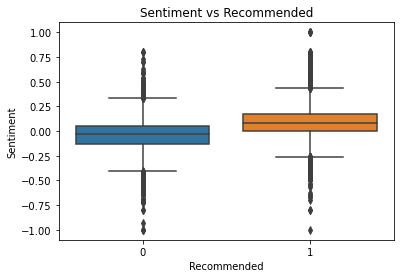

In [39]:
sns.boxplot(x=np.array(result["user_suggestion"]),y=np.array(result["sentiment"]))
plt.xlabel("Recommended")
plt.ylabel("Sentiment")
plt.title("Sentiment vs Recommended")
plt.show()

Improving the sentiment analysis
This was a very simple intro to sentiment analysis. We note that the sentiments calculated are only weakly correlated with the ratings, suggesting that there is a lot of room for improvement. A few basic steps that can be taken to improve our sentiment calculation are:

Pre-processing: Clean up the text. Do stemming/lemmatization. Remove stop words
Remove neutral sentences - Do sentiment analysis of individual sentences in a review and remove neutral ones. Then re-run the sentiment analysis on the polar sentences. This will give a more accurate sentiment score

In [40]:
result.drop(['title','tags'],axis=1,inplace=True)

In [41]:
result.head(2)

,user_review,user_suggestion,sentiment
0,im scared hearing creepy voices ill pause mome...,1,-0.116667
1,best game better sam peppers youtube account n...,1,0.120000


In [42]:
result.sentiment.min()

-1.0

In [43]:
result.sentiment.max()

1.0

In [44]:
X = result.drop('user_suggestion',axis=1)
y = result['user_suggestion']

In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 42, test_size=0.25)

In [46]:
print('\n train X: {} \n train y: {} \n Val X: {} \n val y: {}'.format((X_train.shape),(y_train.shape),(X_test.shape),(y_test.shape)))


 train X: (13120, 2) 
 train y: (13120,) 
 Val X: (4374, 2) 
 val y: (4374,)


In [47]:
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [48]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [49]:
X_train_bert = X_train.user_review
X_test_bert = X_test.user_review



In [70]:
from tqdm import tqdm
train_x_sentiment = []
for review in tqdm(X_train_bert):
    blob = TextBlob(review)
    train_x_sentiment += [blob.sentiment.polarity]

100%|██████████| 13120/13120 [00:15<00:00, 841.42it/s]


In [71]:
from tqdm import tqdm
test_x_sentiment = []
for review in tqdm(X_test_bert):
    blob = TextBlob(review)
    test_x_sentiment += [blob.sentiment.polarity]

100%|██████████| 4374/4374 [00:05<00:00, 871.53it/s]


In [69]:
X_train_bert

5058     early access reviewa throroughly enjoyable gam...
9526     fun game made web browser game open lot text g...
11542    early access reviewi mean mostly play free gam...
10771    early access reviewas fan mtg hearthstone fun ...
184      early access reviewsaw days ago went well cute...
                               ...                        
11284    early access reviewquite fun game blocking mec...
11964    early access reviewtoo many people jumped band...
5390     lets seeâ™¦ half players play like botsâ™¦ gam...
860      early access reviewmy favoured hated game fabu...
15795    early access reviewthis game incredible course...
Name: user_review, Length: 13120, dtype: object

In [50]:
X_train_bert.head(2)

5058    early access reviewa throroughly enjoyable gam...
9526    fun game made web browser game open lot text g...
Name: user_review, dtype: object

In [51]:
def bert_encode(input_text, tokenizer, max_len = 512):
    token_input = [] 
    mask_input = []
    seg_input = []
    
    for text in input_text:
        text = tokenizer.tokenize(text)
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)      
        token_input.append(tokens + [0]*pad_len)
        mask_input.append([1]*len(input_sequence) + [0]*pad_len)
        seg_input.append([0] * max_len)
        
    return np.array(token_input), np.array(mask_input), np.array(seg_input)

In [52]:
def build_model(bert_layer, max_len = 512):
    input_word_ids = Input(shape=(max_len, ),dtype = tf.int32,name = 'input_words_ids')
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")
    
    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [53]:
# X_train_bert.user_review.str.len()

In [54]:
# mean_len = X_train_bert.user_review.str.len().mean()

In [55]:
# mean_len

In [56]:
# X_test_bert.user_review.str.len().mean()

In [57]:
# X_train_bert = pd.Series(X_train_bert)
# X_test_bert =pd.Series(X_test_bert)

In [58]:
type(X_train_bert)

pandas.core.series.Series

In [59]:
train_input = bert_encode(X_train_bert.values, tokenizer, max_len=480)
test_input = bert_encode(X_test_bert.values, tokenizer, max_len=480)
train_labels = y_train.values

In [60]:
testing_input = bert_encode(testing_df.user_review, tokenizer, max_len=480)

In [61]:
type(X_test)

pandas.core.frame.DataFrame

In [62]:
print(type(train_input))
print(type(test_input))
print(type(train_labels))

<class 'tuple'>
<class 'tuple'>
<class 'numpy.ndarray'>


In [63]:
model = build_model(bert_layer, max_len=480)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words_ids (InputLayer)    [(None, 480)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 480)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 480)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_words_ids[0][0]            
                                                                 input_mask[0][0]             

In [64]:
# jhbuh hgvvhb b  ub

In [66]:
train_history = model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=3,
    batch_size=5
)

Train on 10496 samples, validate on 2624 samples
Epoch 1/3
10496/10496 [==============================] - 2237s 213ms/sample - loss: 0.4352 - accuracy: 0.7915 - val_loss: 0.3503 - val_accuracy: 0.8495
Epoch 2/3
10496/10496 [==============================] - 2206s 210ms/sample - loss: 0.2614 - accuracy: 0.8925 - val_loss: 0.3879 - val_accuracy: 0.8457
Epoch 3/3
10496/10496 [==============================] - 2205s 210ms/sample - loss: 0.1104 - accuracy: 0.9596 - val_loss: 0.4360 - val_accuracy: 0.8605


In [67]:
prediction = model.predict(test_input)
preds = []
for x in prediction:
    preds.append(int(x.round()))

from sklearn.metrics import accuracy_score
print("Accuracy: ", accuracy_score(preds, y_test.values))

Accuracy:  0.8625971650663009


# Experiment

In [87]:
X

,user_review,sentiment
0,im scared hearing creepy voices ill pause mome...,-0.116667
1,best game better sam peppers youtube account n...,0.120000
2,littly iffy controls know play easy master ive...,-0.000444
3,great game fun colorful thata side note though...,0.166667
4,not many games cute tag right next horror tag ...,0.048901
...,...,...
17489,arguably single greatest mmorp exists today fr...,0.101720
17490,older game sure charm holds special place hear...,0.028339
17491,frist started playing everquest amazing still ...,0.200615
17492,cool game thing really pisses ridable transpor...,0.037500


In [88]:
super_train = bert_encode(X.user_review.values, tokenizer, max_len=480)

In [89]:
super_prediction = model.predict(super_train)
super_pred = []
for x in super_prediction:
    super_pred.append(int(x.round()))



In [90]:
len(super_pred)

17494

In [91]:
from sklearn.metrics import accuracy_score
print("Accuracy: ", accuracy_score(super_pred, y.values))

Accuracy:  0.9411798330856294


In [92]:
from tqdm import tqdm
super_sentiment = []
for review in tqdm(X.user_review.values):
    blob = TextBlob(review)
    super_sentiment += [blob.sentiment.polarity]

100%|██████████| 17494/17494 [00:20<00:00, 834.76it/s] 


In [93]:
super_dataset = pd.DataFrame(super_pred)
super_dataset['sentiment']=super_sentiment
super_dataset['Target']=y.values

In [94]:
super_dataset.head()

,0,sentiment,Target
0,1,-0.116667,1
1,1,0.120000,1
2,1,-0.000444,1
3,1,0.166667,1
4,1,0.048901,1


In [95]:
super_dataset.shape

(17494, 3)

# Experiment End

# Saving Output

In [96]:
pred_result = prediction = model.predict(testing_input)
submission = pred_result.round().astype(int)
submission=pd.DataFrame(submission)

In [98]:
sub = pd.read_csv('/kaggle/input/steam-recommendation-nlp-dataset/test.csv')
submission['review_id']=sub['review_id']

In [99]:
submission= submission[['review_id',0]]
submission.rename(columns = {0:'user_suggestion'}, inplace = True) 

In [100]:
submission.head(4)

,review_id,user_suggestion
0,1603,1
1,1604,0
2,1605,0
3,1606,0


In [101]:
submission.to_csv('submission_480.csv', index=False)